In [1]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


In [2]:
import numpy as np
import pandas as pd

## Read in the Count Data


In [3]:
target_df = pd.read_parquet(ROOT / Path("data/2023-01-13/count_data.parquet"))

# this is because the 1-13 data is missing Lowes intersections
turn_df = pd.read_parquet(ROOT / Path("data/2023-02-06/count_data.parquet")) 

# replace the date with the date of the target_df
turn_df['cross_time'] = turn_df['cross_time'].apply(lambda x: x.replace(year=2023, month=1, day=13))


In [4]:
# stack the two dataframes
target_df = pd.concat([target_df, turn_df],)

## Relationship Map


In [5]:
box_to_edge = {
    "radar137": {
        "East thru": "gneE11",
        "East left": "gneE31",
        "South left": "gneE0.12",
        "South right": "Airport_to_US69",
    },
    "radar136": {"West thru": "834845345#2", "West right": "8884863"},
    "radar141": {},
    "radar142": {},
}


box_to_relation = {
    "radar136": {},
    "radar137": {},
    "radar141": {
        "West left": ("834845345#5.74.43", "-660891910#1"),
        "North thru": ("660891910#1.19", "638636924#1"),
        "North left": ("660891910#1.19", "834845345#6"),
        "North right": ("gneE4", "115872656#11.5"),
        "West Right": ("gneE2", "638636924#1.8"),
    },
    "radar142": {
        "South thru/right": ("-638636924#1.9", "-660891910#1"),
        "South left": ("-638636924#1.9", "115872656#11"),
    },
}


### Add the Edges to the Count Data


In [6]:
target_df["edge_relation"] = target_df.groupby("radar")["box"].transform(
    lambda x: x.map(box_to_edge[x.name])
)
target_df["turn_relation"] = target_df.groupby("radar")["box"].transform(
    lambda x: x.map(box_to_relation[x.name])
)


In [7]:
target_df

,veh,box,radar,cross_time,edge_relation,turn_relation
0,35256,East thru,radar137,2023-01-13 05:00:09.318196-06:00,gneE11,NaN
1,35269,East thru,radar137,2023-01-13 05:00:59.335435-06:00,gneE11,NaN
2,35270,East thru,radar137,2023-01-13 05:01:02.975583-06:00,gneE11,NaN
3,35272,East thru,radar137,2023-01-13 05:01:00.265357-06:00,gneE11,NaN
4,35273,East thru,radar137,2023-01-13 05:00:59.485421-06:00,gneE11,NaN
...,...,...,...,...,...,...
15453,38872,West dep,radar141,2023-01-13 12:31:07.746713-06:00,NaN,NaN
15454,38873,West dep,radar141,2023-01-13 12:31:09.236714-06:00,NaN,NaN
15455,38875,West thru,radar141,2023-01-13 12:31:09.236714-06:00,NaN,NaN
15456,38877,West dep,radar141,2023-01-13 12:31:09.956713-06:00,NaN,NaN


## Simulation Time


In [8]:
START_TIME = target_df.cross_time.min().replace(minute=0, second=0, microsecond=0)
END_TIME = target_df.cross_time.max().replace(hour=12, minute=0, second=0, microsecond=0)

print(START_TIME, END_TIME)

2023-01-13 05:00:00-06:00 2023-01-13 12:00:00-06:00


In [9]:
count_df = target_df.loc[
    (target_df["cross_time"] >= START_TIME) & (target_df["cross_time"] <= END_TIME)
].copy()


In [10]:
counts = (
    pd.get_dummies(
        count_df["edge_relation"],
    )
    .set_index(
        count_df["cross_time"],
    )
    .resample("1S")
    .sum()
    .fillna(0)
    .astype(int)
)


In [11]:
counts.head()


,834845345#2,8884863,Airport_to_US69,gneE0.12,gneE11,gneE31
cross_time,,,,,,
2023-01-13 05:00:00-06:00,1,0,0,0,0,0
2023-01-13 05:00:01-06:00,1,0,0,0,0,0
2023-01-13 05:00:02-06:00,0,1,0,0,0,0
2023-01-13 05:00:03-06:00,0,0,0,0,0,0
2023-01-13 05:00:04-06:00,0,0,0,0,0,0


In [12]:
turns = (
    pd.get_dummies(
        count_df["turn_relation"],
    )
    .set_index(
        count_df["cross_time"],
    )
    .resample("1S")
    .sum()
    .fillna(0)
    .astype(int)
)


In [13]:
turns.head()

,"(-638636924#1.9, -660891910#1)","(-638636924#1.9, 115872656#11)","(660891910#1.19, 638636924#1)","(660891910#1.19, 834845345#6)","(834845345#5.74.43, -660891910#1)","(gneE4, 115872656#11.5)"
cross_time,,,,,,
2023-01-13 05:00:00-06:00,0,0,0,0,0,0
2023-01-13 05:00:01-06:00,0,0,0,0,0,0
2023-01-13 05:00:02-06:00,0,0,0,0,0,0
2023-01-13 05:00:03-06:00,0,0,0,0,0,0
2023-01-13 05:00:04-06:00,0,0,0,0,0,0


### Save the Data


In [14]:
# save_path = Path(ROOT / "Data" / START_TIME.strftime("%Y-%m-%d"))
# save_path.mkdir(parents=True, exist_ok=True)

# counts.to_parquet(save_path / "counts.parquet")

# turns.columns = [f"{x[0]}~~{x[1]}" for x in turns.columns]
# turns.to_parquet(save_path / "turns.parquet")


### Compare the Simulation Counts to the Count Data


In [15]:
import sumolib
from sumolib.xml import parse_fast_nested

results = parse_fast_nested(
    "/Users/max/Development/sumo-uc-2023/output/CarFollowingDefaults/02.11.2023_17.33.27/0/0_edge.out.xml",
    "interval",
    ("begin"),
    "edge",
    ("id", "sampledSeconds", "entered"),
)

# unpack the nested dict
res = pd.DataFrame(
    [
        {
            "begin": x[0].begin,
            "id": x[1].id,
            "sampledSeconds": x[1].sampledSeconds,
            "departed": x[1].entered,
        }
        for x in results
    ]
)


In [16]:
res[["begin", "sampledSeconds", "departed"]] = res[
    ["begin", "sampledSeconds", "departed"]
].astype(float)
res["dt"] = res["begin"].apply(lambda x: START_TIME + pd.Timedelta(seconds=x))


In [17]:
pivoted_res = pd.pivot(res, index="dt", columns="id", values=["departed"])


In [45]:
### Calculate the GEH
import numpy as np


def geh(m, c):
    return np.sqrt(2 * (m - c) ** 2 / (m + c))


In [19]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
colors = px.colors.qualitative.Plotly


p = 600

counts_df = counts.resample(f"{p}S").sum()
pivoted_res = pivoted_res.resample(f"{p}S").sum()

i = 0
gehs = []
for box in ["West thru", "East thru", "West right", "South left", "South right"]:
    for key in box_to_edge:
        if box in box_to_edge[key]:
            radar = key
            break

    edge = box_to_edge[radar][box]

    fig.add_trace(
        go.Scatter(
            x=pivoted_res.index,
            y=pivoted_res[("departed", edge)],
            name=f"{edge} (sumo)",
            line=dict(
                color=colors[i],
            ),
        )
    )

    fig.add_trace(
        go.Scatter(
            x=counts_df.index,
            y=counts_df[edge],
            name=edge + " (measured)",
            # make the color the same as the line before
            line=dict(color=fig.data[-1].line.color, dash="dot")
            # line=dict(color='royalblue', width=4)
        )
    )
    i += 1

    gehs.append(
        (box,
        (
            geh(
            m=pivoted_res[("departed", edge)] * 3600 / p,
            c=counts_df[edge]* 3600 / p,
        ) < 5).sum() / len(pivoted_res)
        )
    )


fig.update()

fig.show()


In [52]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

# use science plot
plt.style.use("science")
# update the font size
plt.rcParams.update({"font.size": 16})
# create a color palette
palette = plt.get_cmap("tab10")
# create a map of colors for each group
color_map = {i: palette(i) for i in range(6)}

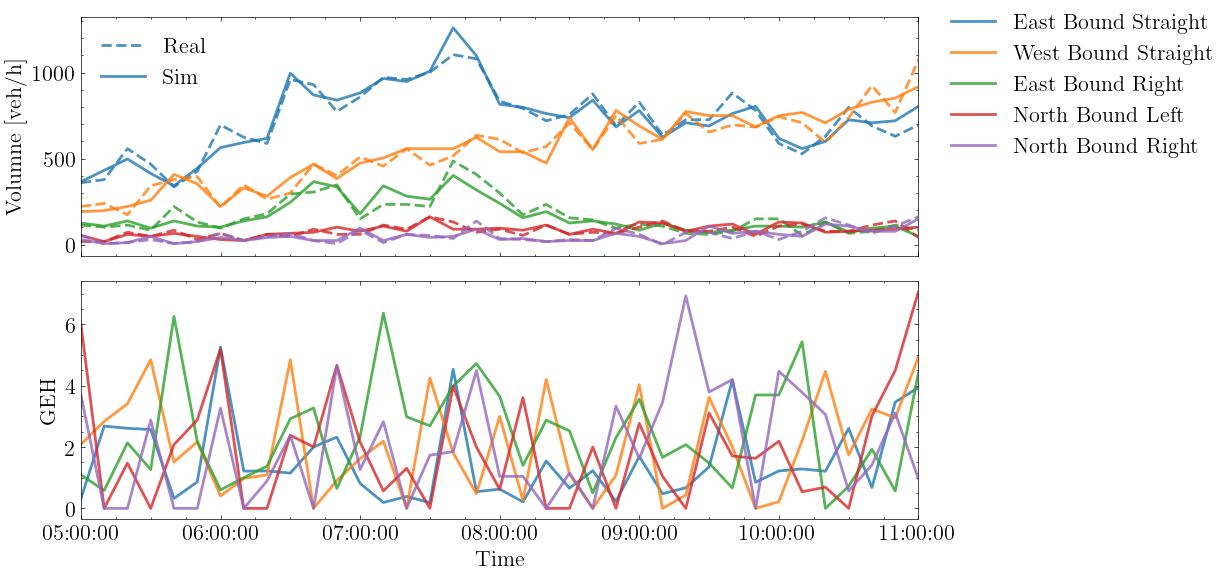

In [97]:
# create a figure with two y-axis
from matplotlib import dates


fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharey=False, sharex=True, tight_layout=True)
# set the font size to 16
plt.rcParams.update({"font.size": 16})

# create a triple paired color map


# filter the index to only show data until 11:00
ax[1].set_xlim([START_TIME, END_TIME - pd.Timedelta(hours=1)])

for i, (box, box_pretty) in enumerate([("West thru", "East Bound Straight"), ("East thru", "West Bound Straight"), ("West right", "East Bound Right"), ("South left", "North Bound Left"), ("South right", "North Bound Right")]):
    # create the color map
    color = color_map[i]

    # add the real
    for key in box_to_edge:
        if box in box_to_edge[key]:
            radar = key
            break

    edge = box_to_edge[radar][box]

    # make the line plot
    ax[0].plot(
        pivoted_res.index,
        pivoted_res[("departed", edge)] * 3600 / p,
        label=f"{box_pretty} (sumo)",
        color=color,
        alpha=0.8,
        # make it thicker
        lw=2,
        ls="--",
        # legend=True,
    )

    # make the line plot
    ax[0].plot(
        counts_df.index,
        counts_df[edge] * 3600 / p,
        label=f"{box_pretty} (measured)",
        color=color,
        alpha=0.8,
        # make it thicker
        lw=2,
        # make it dashed
        # legend=True,

    )

    # add the geh
    geh_ = geh(
            m=pivoted_res[("departed", edge)] * 3600 / p,
            c=counts_df[edge]* 3600 / p,
        )

    # add the geh to a second y-axis
    ax[1].plot(
        counts_df.index,
        geh_,
        label=box_pretty,
        color=color,
        alpha=0.8,
        # make it thicker
        lw=2,
        # make it dashed
    )
    


# style the x-axis date time ticks to just show the time
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S", tz="America/Chicago"))

# update the x-axis label
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Volumne [veh/h]")

# update the y-axis label
ax[1].set_ylabel("GEH")

# only show the legend each color once
handles, labels = ax[0].get_legend_handles_labels()
labels[0] = "Real"
labels[1] = "Sim"

by_label = dict(list(zip(labels, handles))[:2])

# make the text only Real and Sim
ax[0].legend(by_label.values(), by_label.keys(), loc="upper left")

# add a legend to overall figure. move the legend to the upper right, shorten the plots
# and make the legend wider
handles, labels = ax[1].get_legend_handles_labels()
labels = [l.split(" (")[0] for l in labels]
by_label = dict(list(zip(labels, handles)))

fig.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper left",
    bbox_to_anchor=(0.95, 1),
    # bbox_transform=ax[0].transAxes,
    ncol=1,
)






In [151]:
np.mean([g[1] for g in gehs])

0.9578947368421054

In [152]:
gehs

[('West thru', 0.9736842105263158),
 ('East thru', 1.0),
 ('West right', 0.9210526315789473),
 ('South left', 0.9210526315789473),
 ('South right', 0.9736842105263158)]

In [156]:
from sumolib.xml import parse_fast_structured


iters = parse_fast_structured(
    "/Users/max/Development/sumo-uc-2023/output/CarFollowingDefaults/02.11.2023_17.33.27/0/fcd.out.xml",
    "timestep",
    ["time"],
    {"vehicle": ["id"]},
)
df = pd.DataFrame(iters)
# df['vehicle'] = df['vehicle'].apply(lambda x: len(x))
df = df.loc[df["time"].astype(float) % 60 <= 0].copy()
df["vehicle"] = df["vehicle"].apply(lambda x: len(x))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/max/Development/sumo-uc-2023/output/CarFollowingDefaults/02.11.2023_17.33.27/0/fcd.out.xml'

In [31]:
import plotly.express as px

# scatter plot with lines and markers
px.line(
    df,
    x="time",
    y="vehicle",
    title="Number of Vehicles in Simulation",
    labels={"vehicle": "Number of Vehicles", "time": "Time"},
    template="plotly_white",
    width=800,
    height=400,
)
